In [63]:
# author: Michael Hüppe
# date: 16.12.2024
# project: resources/train_model.py
import datetime
import json
import os
import sys
from io import StringIO
from typing import Tuple, List
import pandas as pd
from resources.createModel import init_model
from resources.training.train_logging import SummarizationCallback, WandbLoggingCallback
from resources.inference.generateSummary import GenerateSummary
from resources.preprocessing.dataPreprocessing import tokenizeData, preprocessing
from resources.preprocessing.tokenizer import TokenizerBert, TokenizerWord, Tokenizer, TokenizerBertHuggingFace
from resources.training.rnn.rnn import RNN
from resources.training.transformer.transformer import Transformer
from resources.training.transformer.transformer_decoder_only import TransformerDecoderOnly
from utils.util_readingData import filter_byLength, split_datasets, readingDataArxiv, dataGenerator

# external
import numpy as np
import tensorflow as tf
import wandb


# internal


def train_model(settings: dict, tokenizer: Tokenizer,
                train_dataset: tf.data.Dataset, val_dataset: tf.data.Dataset,
                evaluationBatch: Tuple[List[str], List[str]],
                model_dir: str = None, model_name: str = None):
    try:
        model_type = settings["model_type"]
        model_name = settings.get("run_name", None)

        # Model creation
        if model_type == "Transformer":
            model_class = Transformer
        elif model_type == "TransformerDecoderOnly":
            model_class = TransformerDecoderOnly
        elif model_type == "RNN":
            model_class = RNN

        else:
            raise KeyError
        pre_trained_models_path = settings.get("pre_trained_weights_path", None)
        resume = "allow"

        if pre_trained_models_path:
            try:
                model_settings = json.load(open(os.path.join(pre_trained_models_path, "modelInfo.json")))[
                    "model_parameters"]
                model = init_model(model_class, model_settings)
                model.load_weights(os.path.join(pre_trained_models_path, "modelCheckpoint.weights.h5"))
                model_dir = pre_trained_models_path
            except Exception as e:
                model_name = None
                model_settings = json.load(open(settings["model_params_path"]))
                model = init_model(model_class, model_settings)
                print(f"Pretrained Model Weights could not be loaded due to: {e}")
        else:
            model_name = None
            model_settings = json.load(open(settings["model_params_path"]))
            model_settings.update(settings)
            model_settings["target_vocab_size"] = model_settings.get("vocab_size", 5000)
            model_settings["context_vocab_size"] = model_settings.get("vocab_size", 5000)
            model_settings["model_max_length"] = model_settings.get("context_max_length", 350)
            model = init_model(model_class, model_settings)

        # Iterate through arguments and update the dictionary
        for i in range(0, len(args), 2):  # Assuming arguments are in pairs (key, value)
            key = args[i].strip('--')  # Remove '--' from the key
            if i + 1 < len(args):
                value = args[i + 1]  # The next argument is the value
                # Update the dictionary with the key-value pair
                model_settings[key] = value

        if not model_name:
            model_name = datetime.datetime.now().strftime("%m_%d_%Y__%H_%M_%S")
        if not model_dir:
            model_dir = f"trained_models/{model_type}/{model_name}"
        wandb.init(project=study_name, name=model_name, settings=wandb.Settings(init_timeout=120), resume=resume)

        # Create a unique directory for each model trial
        os.makedirs(model_dir, exist_ok=True)
        model_info_path = os.path.join(model_dir, "modelInfo.json")
        history_path = os.path.join(model_dir, "history.json")
        summary_path = os.path.join(model_dir, "summary.txt")

        wandb.config.update(settings)
        wandb.config.update(model_settings)
        # Callback to stop training early if accuracy does not increase for 5 epochs
        callback = tf.keras.callbacks.EarlyStopping(monitor="val_masked_accuracy",
                                                    patience=settings.get("early_stopping_patience", 20),
                                                    restore_best_weights=True, mode="max")

        # Callback to save model weights
        checkpoint_path = os.path.join(model_dir, "modelCheckpoint.weights.h5")
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            save_freq='epoch'
        )
        # Get model size (sum of all trainable parameters)
        model_size = sum([np.prod(var.shape) for var in model.trainable_variables])

        try:
            with open(summary_path, "w") as f:
                # Pass a function that writes to the file
                model.summary(print_fn=lambda x: f.write(x + "\n"))
        except Exception:
            pass

        with open(model_info_path, "w") as f:
            model_parameters = {"model_parameters": model_settings}
            model_parameters["model_size"] = model_size / 100_000
            json.dump(model_parameters, f)
        wandb.log({"model_size": model_size})

        # Log the model summary string
        # Capture the model summary as a string
        string_io = StringIO()
        model.summary(print_fn=lambda x: string_io.write(x + "\n"))
        model_summary_str = string_io.getvalue()
        wandb.log({"model_summary": model_summary_str})
        target_max_length = settings["target_max_length"]
        titleGenerator = GenerateSummary(model, tokenizer,
                                         target_max_length, context_max_length, decoder_only=decoderOnly)
        val_context = evaluationBatch[0]
        val_reference = evaluationBatch[1]
        summarizationCB = SummarizationCallback(
            titleGenerator=titleGenerator,
            context=val_context[:5],  # Choose a few texts for logging
            reference=val_reference[:5]  # Their corresponding titles
        )

        # Train the model
        steps_per_epoch = settings["steps_per_epoch"]
        # validation_steps = settings["validation_steps"]
        epochs = settings["epochs"]
        initial_epoch = settings.get("initial_epoch", 0)
        history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                            validation_data=val_dataset, epochs=epochs,
                            callbacks=[callback, cp_callback, summarizationCB, WandbLoggingCallback()],
                            validation_steps=validation_steps, initial_epoch=initial_epoch)
        # Save model as an artifact
        artifact = wandb.Artifact(f"model_trial_{model_name}", type="model")
        artifact.add_file(checkpoint_path)
        wandb.log_artifact(artifact)

        # Save the training history
        with open(history_path, "w") as f:
            json.dump(history.history, f)

        # Return both the model size to minimize and score to maximize (Optuna can handle both)
        return model, model_size, history  # Return negative score for maximization
    except Exception as e:
        wandb.log({"error": str(e)})
        print(f"{model_name} was not finished due to: {e}")
        return float('inf'), 0
    finally:
        wandb.finish()


import csv

# Data loading
train_params = json.load(open(r"C:\Users\mhuep\Master_Informatik\Semester_3\MachineLearning\resources\training\train_params.json", "r"))

# Inspect command-line arguments (sys.argv contains all arguments)
args = sys.argv[1:]  # Skip the script name (first argument)

# Iterate through arguments and update the dictionary
for i in range(0, len(args), 2):  # Assuming arguments are in pairs (key, value)
    key = args[i].strip('--')  # Remove '--' from the key
    if i + 1 < len(args):
        value = args[i + 1]  # The next argument is the value
        # Update the dictionary with the key-value pair
        train_params[key] = value

wandb.login(key=train_params["wandb_key"])
override = True
study_name = train_params.get("study_name", "transformer_optimization")
path_train = train_params["data_path_train"]
path_val = train_params["data_path_val"]
steps_per_epoch = train_params["steps_per_epoch"]
validation_steps = train_params["validation_steps"]
epochs = train_params["epochs"]
nTrials = train_params["nTrials"]
input_idx = train_params["input_idx"]
label_idx = train_params["label_idx"]
key_word_idx = train_params.get("key_word_idx", input_idx)
distillation_model_path = train_params.get("distillation_model_path", "")
distill = os.path.isdir(distillation_model_path)

if distill:
    teacher_params = json.load(open(os.path.join(distillation_model_path, "modelInfo.json")))
    distill_model_params = teacher_params["model_parameters"]
    target_max_length, context_max_length = distill_model_params["target_max_length"], distill_model_params[
        "context_max_length"]
    distill_model_params["return_attention_scores"] = False
    teacher_model = init_model(distill_model_params["model_type"], distill_model_params)
    # teacher_model.summary()
    teacher_model.load_weights(os.path.join(distillation_model_path, "modelCheckpoint.weights.h5"))

nEvaluationSamples = train_params["nEvaluationSamples"]
context_min_length = train_params["context_min_length"]
context_max_length = train_params["context_max_length"]
target_min_length = train_params["target_min_length"]
target_max_length = train_params["target_max_length"]
batch_size = train_params["batch_size"]
vocab_size = train_params["vocab_size"]
alpha = train_params.get("alpha", 0.8)

# Mask to discard [UNK] tokens and padding tokens
model_settings = json.load(open(train_params["model_params_path"]))
decoderOnly = train_params["model_type"] == "TransformerDecoderOnly"
vocab_exists = os.path.isfile(train_params["tokenizer_vocab_path"])

import re

# train_df = pd.read_csv(path_train,
#                        usecols=["Unnamed: 0"])
def dataGenerator_preprocessed(file_path, inputs_idx: int = 2, targets_idx: int = 1, key_word_idx: int = None,
                               train: bool = True):
    """
    Reads the csv file line by line so that the
    :param targets_idx: Index of target column
    :param inputs_idx: Index of input column
    :param file_path:
    :return:
    """
    if not key_word_idx:
        key_word_idx = inputs_idx
    while True:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            reader = csv.reader(f, delimiter=",")
            _ = reader.__next__()
            for i, line in enumerate(reader):
                try:
                    # if train and int(line[0]) not in valid_indeces:
                    #     continue

                    input_s = line[inputs_idx]
                    target_s = line[targets_idx]
                    p_input_s = preprocessing(input_s)
                    p_target_s = preprocessing(target_s)
                    # p_input_s = input_s
                    # p_target_s = target_s
                    if key_word_idx != inputs_idx:
                        p_input_s = p_input_s + " | " + line[key_word_idx]
                    if len(p_input_s.split()) < context_min_length or len(
                            p_target_s.split()) < target_min_length:
                        continue
                    yield p_input_s, p_target_s
                except Exception as e:
                    print(e, input_idx, targets_idx, line[0])
                    continue


train_dataset = tf.data.Dataset.from_generator(
    dataGenerator_preprocessed,
    output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                      tf.TensorSpec(shape=(), dtype=tf.string)),
    args=(path_train, input_idx, label_idx, key_word_idx)  # You can change "abstract" to "title" if needed
)
val_dataset = tf.data.Dataset.from_generator(
    dataGenerator_preprocessed,
    output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                      tf.TensorSpec(shape=(), dtype=tf.string)),
    args=(path_val, input_idx, label_idx, key_word_idx, False)  # You can change "abstract" to "title" if needed
)
val_reference = []
val_context = []
for sample in val_dataset.take(batch_size).as_numpy_iterator():
    val_context.append(sample[0])
    val_reference.append(sample[1])

if train_params["tokenizer"] == "bert":
    if not vocab_exists:
        print("No existing vocabulary found. Create new one.")
        TokenizerBert.train(train_dataset, file_path=train_params["tokenizer_vocab_path"],
                            vocab_size=vocab_size)
    tokenizer = TokenizerBert(train_params["tokenizer_vocab_path"])
elif train_params["tokenizer"] == "word":
    if not vocab_exists:
        train_dataset = train_dataset.repeat()
        TokenizerWord.train(
            [title + abstract for title, abstract in train_dataset.take(100_000).as_numpy_iterator()],
            file_path=train_params["tokenizer_vocab_path"],
            vocab_size=vocab_size)
    tokenizer = TokenizerWord(train_params["tokenizer_vocab_path"], target_max_length)
elif train_params["tokenizer"] == "huggingFace":
    if not vocab_exists:
        train_dataset = train_dataset.repeat()
        TokenizerBertHuggingFace.train(
            [title + abstract for title, abstract in train_dataset.take(100_000).as_numpy_iterator()],
            file_path=train_params["tokenizer_vocab_path"])
    tokenizer = TokenizerBertHuggingFace(train_params["tokenizer_vocab_path"])

    def dataGenerator_tokenized(file_path, inputs_idx: int = 2, targets_idx: int = 1, key_word_idx: int = None):
        """
        Reads the csv file line by line so that the
        :param targets_idx: Index of target column
        :param inputs_idx: Index of input column
        :param file_path:
        :return:
        """
        dataGen = dataGenerator_preprocessed(file_path, inputs_idx, targets_idx, key_word_idx)
        for input_s, target_s in dataGen:
            if decoderOnly:
                contexts, targets = tokenizer.tokenize(input_s, frame=True, max_length=-1)[0], \
                    tokenizer.tokenize(target_s, frame=True, max_length=-1)[0]
                # Concatenate along axis 1
                contexts = contexts[:context_max_length]  # Truncate to max length
                targets = targets[:target_max_length]  # Truncate to max length
                concatenatedData = contexts + [tokenizer.TITLE] + targets
                max_len = (context_max_length+target_max_length+1 - len(concatenatedData))
                concatenatedData += [tokenizer.PAD] * max_len  # Pad to max length
                model_input = concatenatedData[:-1]
                model_ouptput = concatenatedData[1:]
                yield model_input, model_ouptput
            else:
                yield tokenizer.tokenize(input_s, frame=True, max_length=context_max_length)[0], \
                    tokenizer.tokenize(target_s, frame=True, max_length=target_max_length)[0]

    c_max_len = context_max_length+target_max_length if decoderOnly else context_max_length
    t_max_len = c_max_len if decoderOnly else target_max_length

    train_dataset = tf.data.Dataset.from_generator(
        dataGenerator_tokenized,
        output_signature=(tf.TensorSpec(shape=c_max_len, dtype=tf.int32),
                          tf.TensorSpec(shape=t_max_len, dtype=tf.int32)),
        args=(path_train, input_idx, label_idx, key_word_idx)
    )
    val_dataset = tf.data.Dataset.from_generator(
        dataGenerator_tokenized,
        output_signature=(tf.TensorSpec(shape=c_max_len, dtype=tf.int32),
                          tf.TensorSpec(shape=t_max_len, dtype=tf.int32)),
        args=(path_val, input_idx, label_idx, key_word_idx)
    )
else:
    raise KeyError


# Preprocessing train and validation datasets

@tf.function
def tokenization(contexts, targets):
    # dynamic tokenizer
    if not decoderOnly:
        if train_params["tokenizer"] in ["bert", "word"]:
            contexts, targets = tokenizeData(contexts, targets,
                                             tokenizer,
                                             context_max_length, target_max_length)
        targets_in = targets[:, :-1]
        targets_out = targets[:, 1:]
        return (contexts, targets_in), targets_out
    else:
        if train_params["tokenizer"] in ["bert", "word"]:
            contexts, targets = tokenizeData(contexts, targets,
                                             tokenizer,
                                             0, 0)

            insert_tensor = tf.fill([tf.shape(contexts)[0], 1], tokenizer.TITLE)  # Shape (None, 1)
            # Concatenate along axis 1
            concatenatedData = tf.concat([contexts, insert_tensor, targets], axis=1)
            concatenatedData = tf.pad(concatenatedData, [[0, 0], [0, 350 - tf.shape(concatenatedData)[1]]])
            contexts = concatenatedData[:, :-1]
            targets = concatenatedData[:, 1:]
        return contexts, targets

train_dataset = train_dataset.batch(batch_size).map(
    tokenization, tf.data.AUTOTUNE
).shuffle(1024).repeat().prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size).map(
    tokenization
).shuffle(1024).repeat().prefetch(tf.data.AUTOTUNE)

train_dataset# author: Michael Hüppe
# date: 16.12.2024
# project: resources/train_model.py
import datetime
import json
import os
import sys
from io import StringIO
from typing import Tuple, List
import pandas as pd
from resources.createModel import init_model
from resources.training.train_logging import SummarizationCallback, WandbLoggingCallback
from resources.inference.generateSummary import GenerateSummary
from resources.preprocessing.dataPreprocessing import tokenizeData, preprocessing
from resources.preprocessing.tokenizer import TokenizerBert, TokenizerWord, Tokenizer, TokenizerBertHuggingFace
from resources.training.rnn.rnn import RNN
from resources.training.transformer.transformer import Transformer
from resources.training.transformer.transformer_decoder_only import TransformerDecoderOnly
from utils.util_readingData import filter_byLength, split_datasets, readingDataArxiv, dataGenerator

# external
import numpy as np
import tensorflow as tf
import wandb


# internal


def train_model(settings: dict, tokenizer: Tokenizer,
                train_dataset: tf.data.Dataset, val_dataset: tf.data.Dataset,
                evaluationBatch: Tuple[List[str], List[str]],
                model_dir: str = None, model_name: str = None):
    try:
        model_type = settings["model_type"]
        model_name = settings.get("run_name", None)

        # Model creation
        if model_type == "Transformer":
            model_class = Transformer
        elif model_type == "TransformerDecoderOnly":
            model_class = TransformerDecoderOnly
        elif model_type == "RNN":
            model_class = RNN

        else:
            raise KeyError
        pre_trained_models_path = settings.get("pre_trained_weights_path", None)
        resume = "allow"

        if pre_trained_models_path:
            try:
                model_settings = json.load(open(os.path.join(pre_trained_models_path, "modelInfo.json")))[
                    "model_parameters"]
                model = init_model(model_class, model_settings)
                model.load_weights(os.path.join(pre_trained_models_path, "modelCheckpoint.weights.h5"))
                model_dir = pre_trained_models_path
            except Exception as e:
                model_name = None
                model_settings = json.load(open(settings["model_params_path"]))
                model = init_model(model_class, model_settings)
                print(f"Pretrained Model Weights could not be loaded due to: {e}")
        else:
            model_name = None
            model_settings = json.load(open(settings["model_params_path"]))
            model_settings.update(settings)
            model_settings["target_vocab_size"] = model_settings.get("vocab_size", 5000)
            model_settings["context_vocab_size"] = model_settings.get("vocab_size", 5000)
            model_settings["model_max_length"] = model_settings.get("context_max_length", 350)
            model = init_model(model_class, model_settings)

        # Iterate through arguments and update the dictionary
        for i in range(0, len(args), 2):  # Assuming arguments are in pairs (key, value)
            key = args[i].strip('--')  # Remove '--' from the key
            if i + 1 < len(args):
                value = args[i + 1]  # The next argument is the value
                # Update the dictionary with the key-value pair
                model_settings[key] = value

        if not model_name:
            model_name = datetime.datetime.now().strftime("%m_%d_%Y__%H_%M_%S")
        if not model_dir:
            model_dir = f"trained_models/{model_type}/{model_name}"
        wandb.init(project=study_name, name=model_name, settings=wandb.Settings(init_timeout=120), resume=resume)

        # Create a unique directory for each model trial
        os.makedirs(model_dir, exist_ok=True)
        model_info_path = os.path.join(model_dir, "modelInfo.json")
        history_path = os.path.join(model_dir, "history.json")
        summary_path = os.path.join(model_dir, "summary.txt")

        wandb.config.update(settings)
        wandb.config.update(model_settings)
        # Callback to stop training early if accuracy does not increase for 5 epochs
        callback = tf.keras.callbacks.EarlyStopping(monitor="val_masked_accuracy",
                                                    patience=settings.get("early_stopping_patience", 20),
                                                    restore_best_weights=True, mode="max")

        # Callback to save model weights
        checkpoint_path = os.path.join(model_dir, "modelCheckpoint.weights.h5")
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            save_freq='epoch'
        )
        # Get model size (sum of all trainable parameters)
        model_size = sum([np.prod(var.shape) for var in model.trainable_variables])

        try:
            with open(summary_path, "w") as f:
                # Pass a function that writes to the file
                model.summary(print_fn=lambda x: f.write(x + "\n"))
        except Exception:
            pass

        with open(model_info_path, "w") as f:
            model_parameters = {"model_parameters": model_settings}
            model_parameters["model_size"] = model_size / 100_000
            json.dump(model_parameters, f)
        wandb.log({"model_size": model_size})

        # Log the model summary string
        # Capture the model summary as a string
        string_io = StringIO()
        model.summary(print_fn=lambda x: string_io.write(x + "\n"))
        model_summary_str = string_io.getvalue()
        wandb.log({"model_summary": model_summary_str})
        target_max_length = settings["target_max_length"]
        titleGenerator = GenerateSummary(model, tokenizer,
                                         target_max_length, context_max_length, decoder_only=decoderOnly)
        val_context = evaluationBatch[0]
        val_reference = evaluationBatch[1]
        summarizationCB = SummarizationCallback(
            titleGenerator=titleGenerator,
            context=val_context[:5],  # Choose a few texts for logging
            reference=val_reference[:5]  # Their corresponding titles
        )

        # Train the model
        steps_per_epoch = settings["steps_per_epoch"]
        # validation_steps = settings["validation_steps"]
        epochs = settings["epochs"]
        initial_epoch = settings.get("initial_epoch", 0)
        history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                            validation_data=val_dataset, epochs=epochs,
                            callbacks=[callback, cp_callback, summarizationCB, WandbLoggingCallback()],
                            validation_steps=validation_steps, initial_epoch=initial_epoch)
        # Save model as an artifact
        artifact = wandb.Artifact(f"model_trial_{model_name}", type="model")
        artifact.add_file(checkpoint_path)
        wandb.log_artifact(artifact)

        # Save the training history
        with open(history_path, "w") as f:
            json.dump(history.history, f)

        # Return both the model size to minimize and score to maximize (Optuna can handle both)
        return model, model_size, history  # Return negative score for maximization
    except Exception as e:
        wandb.log({"error": str(e)})
        print(f"{model_name} was not finished due to: {e}")
        return float('inf'), 0
    finally:
        wandb.finish()


import csv

# Data loading
train_params = json.load(open(r"C:\Users\mhuep\Master_Informatik\Semester_3\MachineLearning\resources\training\train_params.json", "r"))

# Inspect command-line arguments (sys.argv contains all arguments)
args = sys.argv[1:]  # Skip the script name (first argument)

# Iterate through arguments and update the dictionary
for i in range(0, len(args), 2):  # Assuming arguments are in pairs (key, value)
    key = args[i].strip('--')  # Remove '--' from the key
    if i + 1 < len(args):
        value = args[i + 1]  # The next argument is the value
        # Update the dictionary with the key-value pair
        train_params[key] = value

wandb.login(key=train_params["wandb_key"])
override = True
study_name = train_params.get("study_name", "transformer_optimization")
path_train = train_params["data_path_train"]
path_val = train_params["data_path_val"]
steps_per_epoch = train_params["steps_per_epoch"]
validation_steps = train_params["validation_steps"]
epochs = train_params["epochs"]
nTrials = train_params["nTrials"]
input_idx = train_params["input_idx"]
label_idx = train_params["label_idx"]
key_word_idx = train_params.get("key_word_idx", input_idx)
distillation_model_path = train_params.get("distillation_model_path", "")
distill = os.path.isdir(distillation_model_path)

if distill:
    teacher_params = json.load(open(os.path.join(distillation_model_path, "modelInfo.json")))
    distill_model_params = teacher_params["model_parameters"]
    target_max_length, context_max_length = distill_model_params["target_max_length"], distill_model_params[
        "context_max_length"]
    distill_model_params["return_attention_scores"] = False
    teacher_model = init_model(distill_model_params["model_type"], distill_model_params)
    # teacher_model.summary()
    teacher_model.load_weights(os.path.join(distillation_model_path, "modelCheckpoint.weights.h5"))

nEvaluationSamples = train_params["nEvaluationSamples"]
context_min_length = train_params["context_min_length"]
context_max_length = train_params["context_max_length"]
target_min_length = train_params["target_min_length"]
target_max_length = train_params["target_max_length"]
batch_size = train_params["batch_size"]
vocab_size = train_params["vocab_size"]
alpha = train_params.get("alpha", 0.8)

# Mask to discard [UNK] tokens and padding tokens
model_settings = json.load(open(train_params["model_params_path"]))
decoderOnly = train_params["model_type"] == "TransformerDecoderOnly"
vocab_exists = os.path.isfile(train_params["tokenizer_vocab_path"])

import re

# train_df = pd.read_csv(path_train,
#                        usecols=["Unnamed: 0"])
def dataGenerator_preprocessed(file_path, inputs_idx: int = 2, targets_idx: int = 1, key_word_idx: int = None,
                               train: bool = True):
    """
    Reads the csv file line by line so that the
    :param targets_idx: Index of target column
    :param inputs_idx: Index of input column
    :param file_path:
    :return:
    """
    if not key_word_idx:
        key_word_idx = inputs_idx
    while True:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            reader = csv.reader(f, delimiter=",")
            _ = reader.__next__()
            for i, line in enumerate(reader):
                try:
                    # if train and int(line[0]) not in valid_indeces:
                    #     continue

                    input_s = line[inputs_idx]
                    target_s = line[targets_idx]
                    p_input_s = preprocessing(input_s)
                    p_target_s = preprocessing(target_s)
                    # p_input_s = input_s
                    # p_target_s = target_s
                    if key_word_idx != inputs_idx:
                        p_input_s = p_input_s + " | " + line[key_word_idx]
                    if len(p_input_s.split()) < context_min_length or len(
                            p_target_s.split()) < target_min_length:
                        continue
                    yield p_input_s, p_target_s
                except Exception as e:
                    print(e, input_idx, targets_idx, line[0])
                    continue


train_dataset = tf.data.Dataset.from_generator(
    dataGenerator_preprocessed,
    output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                      tf.TensorSpec(shape=(), dtype=tf.string)),
    args=(path_train, input_idx, label_idx, key_word_idx)  # You can change "abstract" to "title" if needed
)
val_dataset = tf.data.Dataset.from_generator(
    dataGenerator_preprocessed,
    output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                      tf.TensorSpec(shape=(), dtype=tf.string)),
    args=(path_val, input_idx, label_idx, key_word_idx, False)  # You can change "abstract" to "title" if needed
)
val_reference = []
val_context = []
for sample in val_dataset.take(batch_size).as_numpy_iterator():
    val_context.append(sample[0])
    val_reference.append(sample[1])

if train_params["tokenizer"] == "bert":
    if not vocab_exists:
        print("No existing vocabulary found. Create new one.")
        TokenizerBert.train(train_dataset, file_path=train_params["tokenizer_vocab_path"],
                            vocab_size=vocab_size)
    tokenizer = TokenizerBert(train_params["tokenizer_vocab_path"])
elif train_params["tokenizer"] == "word":
    if not vocab_exists:
        train_dataset = train_dataset.repeat()
        TokenizerWord.train(
            [title + abstract for title, abstract in train_dataset.take(100_000).as_numpy_iterator()],
            file_path=train_params["tokenizer_vocab_path"],
            vocab_size=vocab_size)
    tokenizer = TokenizerWord(train_params["tokenizer_vocab_path"], target_max_length)
elif train_params["tokenizer"] == "huggingFace":
    if not vocab_exists:
        train_dataset = train_dataset.repeat()
        TokenizerBertHuggingFace.train(
            [title + abstract for title, abstract in train_dataset.take(100_000).as_numpy_iterator()],
            file_path=train_params["tokenizer_vocab_path"])
    tokenizer = TokenizerBertHuggingFace(train_params["tokenizer_vocab_path"])

    def dataGenerator_tokenized(file_path, inputs_idx: int = 2, targets_idx: int = 1, key_word_idx: int = None):
        """
        Reads the csv file line by line so that the
        :param targets_idx: Index of target column
        :param inputs_idx: Index of input column
        :param file_path:
        :return:
        """
        dataGen = dataGenerator_preprocessed(file_path, inputs_idx, targets_idx, key_word_idx)
        for input_s, target_s in dataGen:
            if decoderOnly:
                contexts, targets = tokenizer.tokenize(input_s, frame=False, max_length=-1)[0], \
                    tokenizer.tokenize(target_s, frame=False, max_length=-1)[0]
                # Concatenate along axis 1
                contexts = contexts[:context_max_length]  # Truncate to max length
                targets = targets[:target_max_length]  # Truncate to max length
                concatenatedData = [tokenizer.START] + contexts + [tokenizer.TITLE] + targets + [tokenizer.END]
                max_len = context_max_length+target_max_length+1
                concatenatedData += [tokenizer.PAD] * (max_len - len(concatenatedData))  # Pad to max length
                concatenatedData = concatenatedData[:max_len]
                model_input = concatenatedData[:-1]
                model_ouptput = concatenatedData[1:]

                yield model_input, model_ouptput
            else:
                yield tokenizer.tokenize(input_s, frame=True, max_length=context_max_length)[0], \
                    tokenizer.tokenize(target_s, frame=True, max_length=target_max_length)[0]

    c_max_len = context_max_length+target_max_length if decoderOnly else context_max_length
    t_max_len = c_max_len if decoderOnly else target_max_length

    train_dataset = tf.data.Dataset.from_generator(
        dataGenerator_tokenized,
        output_signature=(tf.TensorSpec(shape=c_max_len, dtype=tf.int32),
                          tf.TensorSpec(shape=t_max_len, dtype=tf.int32)),
        args=(path_train, input_idx, label_idx, key_word_idx)
    )
    val_dataset = tf.data.Dataset.from_generator(
        dataGenerator_tokenized,
        output_signature=(tf.TensorSpec(shape=c_max_len, dtype=tf.int32),
                          tf.TensorSpec(shape=t_max_len, dtype=tf.int32)),
        args=(path_val, input_idx, label_idx, key_word_idx)
    )
else:
    raise KeyError


# Preprocessing train and validation datasets

@tf.function
def tokenization(contexts, targets):
    # dynamic tokenizer
    if not decoderOnly:
        if train_params["tokenizer"] in ["bert", "word"]:
            contexts, targets = tokenizeData(contexts, targets,
                                             tokenizer,
                                             context_max_length, target_max_length)
        targets_in = targets[:, :-1]
        targets_out = targets[:, 1:]
        return (contexts, targets_in), targets_out
    else:
        if train_params["tokenizer"] in ["bert", "word"]:
            contexts, targets = tokenizeData(contexts, targets,
                                             tokenizer,
                                             0, 0)

            insert_tensor = tf.fill([tf.shape(contexts)[0], 1], tokenizer.TITLE)  # Shape (None, 1)
            # Concatenate along axis 1
            concatenatedData = tf.concat([contexts, insert_tensor, targets], axis=1)
            concatenatedData = tf.pad(concatenatedData, [[0, 0], [0, 350 - tf.shape(concatenatedData)[1]]])
            contexts = concatenatedData[:, :-1]
            targets = concatenatedData[:, 1:]
        return contexts, targets

train_dataset = train_dataset.batch(batch_size).map(
    tokenization, tf.data.AUTOTUNE
).shuffle(10).repeat().prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size).map(
    tokenization
).shuffle(10).repeat().prefetch(tf.data.AUTOTUNE)

train_dataset

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\mhuep\_netrc
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\mhuep\_netrc


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 390), dtype=tf.int32, name=None), TensorSpec(shape=(None, 390), dtype=tf.int32, name=None))>

In [64]:
data_batch = list(train_dataset.take(1).as_numpy_iterator())

In [65]:
context, label = data_batch[0]
idx = 3
print(tokenizer.detokenize(context[idx]).replace(" ##", ""))
print("#"*10)
print(tokenizer.detokenize(label[idx]).replace(" ##", ""))

there has been important experimental progress in the sector of heavy baryons in the past several years . we study the strong decays of the s wave , p wave , d wave and radially excited charmed baryons using the p model . after comparing the calculated decay pattern and total width with the available data , we discuss the possible internal structure and quantum numbers of those charmed baryons observed recently . [TITLE] strong decays of charmed baryons
##########
there has been important experimental progress in the sector of heavy baryons in the past several years . we study the strong decays of the s wave , p wave , d wave and radially excited charmed baryons using the p model . after comparing the calculated decay pattern and total width with the available data , we discuss the possible internal structure and quantum numbers of those charmed baryons observed recently . [TITLE] strong decays of charmed baryons


In [67]:
np.asarray([context[0], label[0]])

array([[   2,   77,  143, ...,    0,    0,    0],
       [   2,   79, 4067, ...,    0,    0,    0],
       [   2,   86,  118, ...,    0,    0,    0],
       ...,
       [   2,   79,  143, ...,    0,    0,    0],
       [   2,   79,  643, ...,    0,    0,    0],
       [   2,   79,  349, ...,    0,    0,    0]], dtype=int32)

In [98]:
settings = train_params
model_type = settings["model_type"]
model_name = settings.get("run_name", None)

# Model creation
if model_type == "Transformer":
    model_class = Transformer
elif model_type == "TransformerDecoderOnly":
    model_class = TransformerDecoderOnly
elif model_type == "RNN":
    model_class = RNN

else:
    raise KeyError
pre_trained_models_path = settings.get("pre_trained_weights_path", None)
resume = "allow"

model_settings = json.load(open(settings["model_params_path"]))
model_settings.update(settings)
model_settings["target_vocab_size"] = model_settings.get("vocab_size", 5000)
model_settings["context_vocab_size"] = model_settings.get("vocab_size", 5000)
model_settings["model_max_length"] = model_settings.get("context_max_length", 350)
model = init_model(model_class, model_settings)

# Iterate through arguments and update the dictionary
for i in range(0, len(args), 2):  # Assuming arguments are in pairs (key, value)
    key = args[i].strip('--')  # Remove '--' from the key
    if i + 1 < len(args):
        value = args[i + 1]  # The next argument is the value
        # Update the dictionary with the key-value pair
        model_settings[key] = value

if not model_name:
    model_name = datetime.datetime.now().strftime("%m_%d_%Y__%H_%M_%S")

model_dir = f"trained_models/{model_type}/{model_name}"
wandb.init(project=study_name, name=model_name, settings=wandb.Settings(init_timeout=120), resume=resume)

# Create a unique directory for each model trial
os.makedirs(model_dir, exist_ok=True)
model_info_path = os.path.join(model_dir, "modelInfo.json")
history_path = os.path.join(model_dir, "history.json")
summary_path = os.path.join(model_dir, "summary.txt")

wandb.config.update(settings)
wandb.config.update(model_settings)
# Callback to stop training early if accuracy does not increase for 5 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor="val_masked_accuracy",
                                            patience=settings.get("early_stopping_patience", 20),
                                            restore_best_weights=True, mode="max")

# Callback to save model weights
checkpoint_path = os.path.join(model_dir, "modelCheckpoint.weights.h5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)
# Get model size (sum of all trainable parameters)
model_size = sum([np.prod(var.shape) for var in model.trainable_variables])
model.summary()
try:
    with open(summary_path, "w") as f:
        # Pass a function that writes to the file
        model.summary(print_fn=lambda x: f.write(x + "\n"))
except Exception:
    pass

with open(model_info_path, "w") as f:
    model_parameters = {"model_parameters": model_settings}
    model_parameters["model_size"] = model_size / 100_000
    json.dump(model_parameters, f)
wandb.log({"model_size": model_size})

# Log the model summary string
# Capture the model summary as a string
string_io = StringIO()
model.summary(print_fn=lambda x: string_io.write(x + "\n"))
model_summary_str = string_io.getvalue()
wandb.log({"model_summary": model_summary_str})
target_max_length = settings["target_max_length"]
titleGenerator = GenerateSummary(model, tokenizer,
                                 target_max_length, context_max_length, decoder_only=decoderOnly)
val_context = context
val_reference = label
summarizationCB = SummarizationCallback(
    titleGenerator=titleGenerator,
    context=val_context[:5],  # Choose a few texts for logging
    reference=val_reference[:5]  # Their corresponding titles
)

# Train the model
steps_per_epoch = settings["steps_per_epoch"]
# validation_steps = settings["validation_steps"]
epochs = settings["epochs"]
initial_epoch = settings.get("initial_epoch", 0)

Model: "Transformer_Decoder_Only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 100)      │       767,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, None, 100)      │             0 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_1 (Functional)    │ [(None, None, 100),    │        50,900 │
│                                 │ (None, 2, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 7671)     │       774,771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,592,771 (6.08 MB)

 Trainable params: 1,592,771 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
history = model.fit(context, label, epochs=1000)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 8.9375 - masked_accuracy: 0.0000e+00
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 8.9414 - masked_accuracy: 0.0000e+00
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 8.9360 - masked_accuracy: 0.0000e+00
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 8.9386 - masked_accuracy: 0.0000e+00
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 8.9385 - masked_accuracy: 0.0000e+00
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 8.9392 - masked_accuracy: 0.0000e+00
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 8.9367 - masked_accuracy: 0.0000e+00
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 8.9345 - masked_accuracy: 0.0000e+00
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 8.9359 - masked_accuracy: 0.0000e+00
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 8.9336 - masked_accuracy: 0.0000e+00
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━

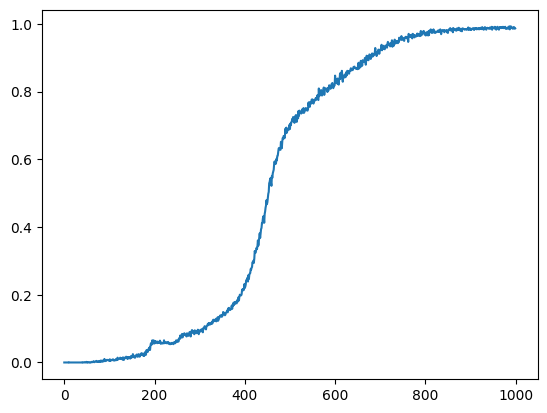

In [104]:
import matplotlib.pyplot as plt
plt.plot(history.history["masked_accuracy"])
plt.show()

In [124]:
import importlib
from resources.inference import generateSummary

importlib.reload(generateSummary)  # Reload the module

from resources.inference.generateSummary import GenerateSummary  # Re-import the class

titleGenerator = GenerateSummary(model, tokenizer,
                                 target_max_length, context_max_length, decoder_only=decoderOnly)
tokenizer.detokenize(context[2]).replace(" ##", "")

'this paper is an exposition of the so called injective morita contexts in which the connecting bimodule morphisms are injective and morita alphacontexts in which the connecting bimodules enjoy some local projectivity in the sense of zimmermann huisgen . motivated by situations in which only one trace ideal is in action , or the compatibility between the bimodule morphisms is not needed , we introduce the notions of morita semi contexts and morita data , and investigate them . injective morita data will be used with the help of static and adstatic modules to establish equivalences between some intersecting subcategories related to subcategories of modules that are localized or colocalized by trace ideals of a morita datum . we end up with applications of morita alpha contexts to ast modules and injective right wide morita contexts . [TITLE] injective morita contexts revisited'

In [146]:
prediction = model.predict(context)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


array([[[-10.95837  , -11.757899 , -11.780229 , ..., -11.593511 ,
         -11.996234 , -11.946051 ],
        [ -6.4205174,  -4.9953465,  -5.628798 , ...,  -5.222023 ,
          -6.1359076,  -5.9082828],
        [ -6.7912326,  -5.9505243,  -6.4808936, ...,  -6.326792 ,
          -7.026348 ,  -6.305648 ],
        ...,
        [ -7.396225 ,  -7.5455766,  -7.582988 , ...,  -8.09946  ,
          -7.220883 ,  -6.580205 ],
        [ -7.3898015,  -7.573859 ,  -7.606662 , ...,  -8.250721 ,
          -7.447953 ,  -6.643078 ],
        [ -7.4250093,  -7.666181 ,  -7.6432533, ...,  -8.3083315,
          -7.607979 ,  -6.674971 ]],

       [[-10.95837  , -11.757899 , -11.780229 , ..., -11.593511 ,
         -11.996234 , -11.946051 ],
        [ -5.5668173,  -5.4012675,  -5.82161  , ...,  -6.013739 ,
          -5.5948863,  -5.607107 ],
        [ -7.5858984,  -8.231738 ,  -8.51269  , ...,  -7.88427  ,
          -8.363996 ,  -8.738932 ],
        ...,
        [ -6.7866206,  -7.0778956,  -7.241984 , ...,  

In [147]:
label

array([[  77,  143,  118, ...,    0,    0,    0],
       [  79, 4067,   52, ...,    0,    0,    0],
       [  86,  118,   81, ...,    0,    0,    0],
       ...,
       [  79,  143,   42, ...,    0,    0,    0],
       [  79,  643,  111, ...,    0,    0,    0],
       [  79,  349,  495, ...,    0,    0,    0]], dtype=int32)

In [143]:
tokenizer.detokenize(context[0]).replace(" ##", "")

'in present paper we propose seemingly new method for finding solutions of some types of nonlinear pdes in closed form . the method is based on decomposition of nonlinear operators on sequence of operators of lower orders . it is shown that decomposition process can be done by iterative procedures , each step of which is reduced to solution of some auxiliary pdes systems for one dependent variable . moreover , we find on this way the explicit expression of the first order pdes for first integral of decomposable initial pde . remarkably that this first order pde is linear if initial pde is linear in its highest derivatives . the developed method is implemented in maple procedure , which can really solve many of different order pdes with different number of independent variables . examples of pdes with calculated their general solutions demonstrate a potential of the method for automatic solving of nonlinear pdes . [TITLE] the decomposition method and maple procedure for finding first in

In [148]:
np.argmax(prediction, axis=-1)

array([[  79,  143,  118, ...,   83,   83,   83],
       [  79, 4067,   52, ...,   83,   83,   83],
       [  79,  118,   81, ...,   83,   83,   83],
       ...,
       [  79, 4067,   42, ...,   76,   83,   83],
       [  79, 4067,  111, ...,   80,   85,   83],
       [  79, 4067,  495, ...,   83,   83,   83]])